# Notebook 1: Neural ODE 2D Classification

Este notebook implementa e treina Neural ODEs para classificação em dados 2D.

## Objetivos:
1. Implementar VectorField e NeuralODE com classificação
2. Treinar em dataset 2D sintético (moons, circles, spirals)
3. Visualizar trajetórias a partir de dados do dataset (x(0) → x(1))
4. Visualizar transformações a partir de z ~ N(0,I) (z(0) → x(1))
5. Visualizar vector fields
6. Analisar NFEs e comparar solvers


In [1]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')
import torch
import torch.optim as optim
from src.models.neural_ode import NeuralODE
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, get_dataloader
from src.utils.training import train_neural_ode, count_nfe
from src.utils.visualization import Synthetic2DViz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Directories for saving figures and checkpoints
FIGURES_DIR = '../results/figures'
CHECKPOINTS_DIR = '../results/checkpoints'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Dataset and model names for file naming
DATASET_NAME = 'moons'
MODEL_NAME = 'neuralode'


Using device: cpu


## 1. Carregar Dataset


Figure saved to: ../results/figures/01_moons_neuralode.png


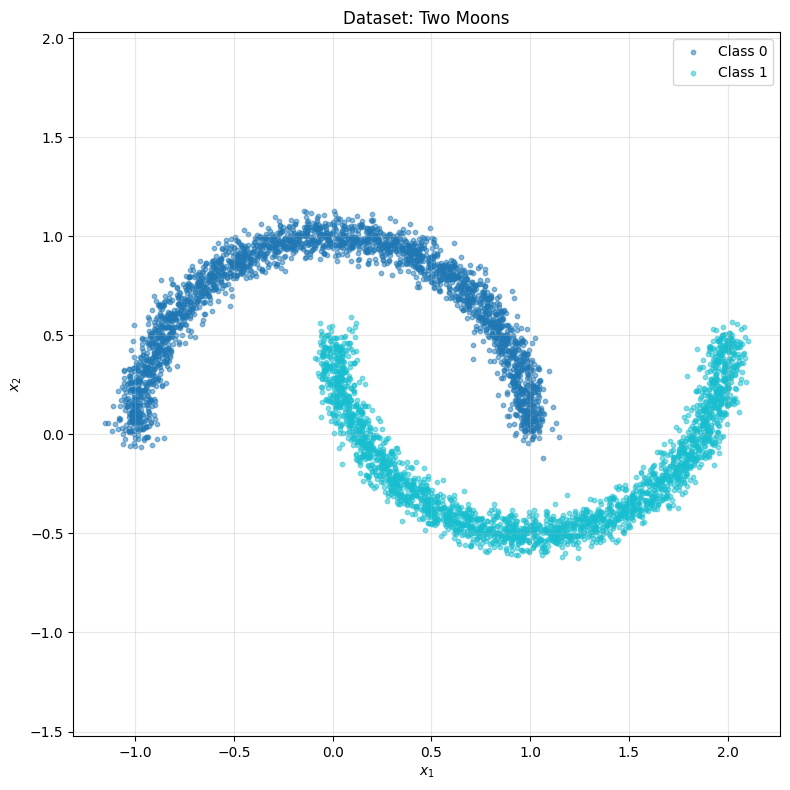

Dataset size: 5000
Number of classes: 2


In [7]:
# Criar dataset (moons, circles, ou spirals - todos têm 2 classes)
dataset = Synthetic2D(n_samples=5000, noise=0.05, dataset_type='moons')
dataloader = get_dataloader(dataset, batch_size=128, shuffle=True)

# Visualizar dados com cores por classe
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
Synthetic2DViz.plot_data_distribution(
    dataset.data,
    labels=dataset.labels,
    ax=ax,
    title="Dataset: Two Moons",
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}.png')
)
plt.tight_layout()
plt.show()

print(f"Dataset size: {len(dataset)}")
print(f"Number of classes: {len(torch.unique(dataset.labels))}")


## 2. Criar e Treinar Modelo


In [3]:
# Criar modelo com classificação (2 classes para moons/circles/spirals)
vf = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
model = NeuralODE(
    vf,
    solver='rk4',
    rtol=1e-5,
    atol=1e-5,
    num_classes=2  # 2 classes para datasets sintéticos
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Treinar para classificação
train_neural_ode(model, dataloader, optimizer, device, num_epochs=50)

# Salvar checkpoint
checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'01__{DATASET_NAME}_{MODEL_NAME}.pt')
torch.save(model.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")


Epoch 1/50:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Epoch 1, Loss: 0.514510, Accuracy: 77.72%


Epoch 2/50: 100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Epoch 2, Loss: 0.276337, Accuracy: 87.36%


Epoch 3/50: 100%|██████████| 40/40 [00:05<00:00,  7.00it/s]


Epoch 3, Loss: 0.229991, Accuracy: 89.38%


Epoch 4/50: 100%|██████████| 40/40 [00:04<00:00,  8.51it/s]


Epoch 4, Loss: 0.216162, Accuracy: 89.66%


Epoch 5/50: 100%|██████████| 40/40 [00:05<00:00,  7.91it/s]


Epoch 5, Loss: 0.199593, Accuracy: 90.60%


Epoch 6/50: 100%|██████████| 40/40 [00:05<00:00,  6.82it/s]


Epoch 6, Loss: 0.180547, Accuracy: 91.00%


Epoch 7/50: 100%|██████████| 40/40 [00:06<00:00,  6.20it/s]


Epoch 7, Loss: 0.166578, Accuracy: 92.12%


Epoch 8/50: 100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Epoch 8, Loss: 0.144891, Accuracy: 93.32%


Epoch 9/50: 100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Epoch 9, Loss: 0.130007, Accuracy: 94.42%


Epoch 10/50: 100%|██████████| 40/40 [00:04<00:00,  8.24it/s]


Epoch 10, Loss: 0.105168, Accuracy: 95.66%


Epoch 11/50: 100%|██████████| 40/40 [00:06<00:00,  6.62it/s]


Epoch 11, Loss: 0.085024, Accuracy: 96.94%


Epoch 12/50: 100%|██████████| 40/40 [00:05<00:00,  7.40it/s]


Epoch 12, Loss: 0.068107, Accuracy: 97.86%


Epoch 13/50: 100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


Epoch 13, Loss: 0.052673, Accuracy: 98.82%


Epoch 14/50: 100%|██████████| 40/40 [00:04<00:00,  8.06it/s]


Epoch 14, Loss: 0.039944, Accuracy: 99.54%


Epoch 15/50: 100%|██████████| 40/40 [00:05<00:00,  7.41it/s]


Epoch 15, Loss: 0.030583, Accuracy: 99.76%


Epoch 16/50: 100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


Epoch 16, Loss: 0.024106, Accuracy: 99.94%


Epoch 17/50: 100%|██████████| 40/40 [00:04<00:00,  9.38it/s]


Epoch 17, Loss: 0.018932, Accuracy: 99.96%


Epoch 18/50: 100%|██████████| 40/40 [00:04<00:00,  9.42it/s]


Epoch 18, Loss: 0.015532, Accuracy: 99.96%


Epoch 19/50: 100%|██████████| 40/40 [00:04<00:00,  8.45it/s]


Epoch 19, Loss: 0.012734, Accuracy: 99.96%


Epoch 20/50: 100%|██████████| 40/40 [00:04<00:00,  9.37it/s]


Epoch 20, Loss: 0.012005, Accuracy: 99.96%


Epoch 21/50: 100%|██████████| 40/40 [00:04<00:00,  8.98it/s]


Epoch 21, Loss: 0.011708, Accuracy: 100.00%


Epoch 22/50: 100%|██████████| 40/40 [00:04<00:00,  9.35it/s]


Epoch 22, Loss: 0.007572, Accuracy: 99.98%


Epoch 23/50: 100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


Epoch 23, Loss: 0.006712, Accuracy: 99.98%


Epoch 24/50: 100%|██████████| 40/40 [00:04<00:00,  9.38it/s]


Epoch 24, Loss: 0.006108, Accuracy: 99.98%


Epoch 25/50: 100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


Epoch 25, Loss: 0.004861, Accuracy: 100.00%


Epoch 26/50: 100%|██████████| 40/40 [00:03<00:00, 10.41it/s]


Epoch 26, Loss: 0.004285, Accuracy: 99.98%


Epoch 27/50: 100%|██████████| 40/40 [00:04<00:00,  9.78it/s]


Epoch 27, Loss: 0.003759, Accuracy: 99.98%


Epoch 28/50: 100%|██████████| 40/40 [00:03<00:00, 10.53it/s]


Epoch 28, Loss: 0.003558, Accuracy: 99.98%


Epoch 29/50: 100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


Epoch 29, Loss: 0.003009, Accuracy: 100.00%


Epoch 30/50: 100%|██████████| 40/40 [00:04<00:00,  9.81it/s]


Epoch 30, Loss: 0.002780, Accuracy: 100.00%


Epoch 31/50: 100%|██████████| 40/40 [00:03<00:00, 10.71it/s]


Epoch 31, Loss: 0.002500, Accuracy: 100.00%


Epoch 32/50: 100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


Epoch 32, Loss: 0.002381, Accuracy: 100.00%


Epoch 33/50: 100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


Epoch 33, Loss: 0.002189, Accuracy: 100.00%


Epoch 34/50: 100%|██████████| 40/40 [00:05<00:00,  7.96it/s]


Epoch 34, Loss: 0.002010, Accuracy: 100.00%


Epoch 35/50: 100%|██████████| 40/40 [00:04<00:00,  8.72it/s]


Epoch 35, Loss: 0.001926, Accuracy: 100.00%


Epoch 36/50: 100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Epoch 36, Loss: 0.001716, Accuracy: 100.00%


Epoch 37/50: 100%|██████████| 40/40 [00:05<00:00,  7.45it/s]


Epoch 37, Loss: 0.001553, Accuracy: 100.00%


Epoch 38/50:  38%|███▊      | 15/40 [00:01<00:03,  8.04it/s]


KeyboardInterrupt: 

## 3. Visualizar Trajetórias


Figure saved to: ../results/figures/01_moons_neuralode_trajectories.png


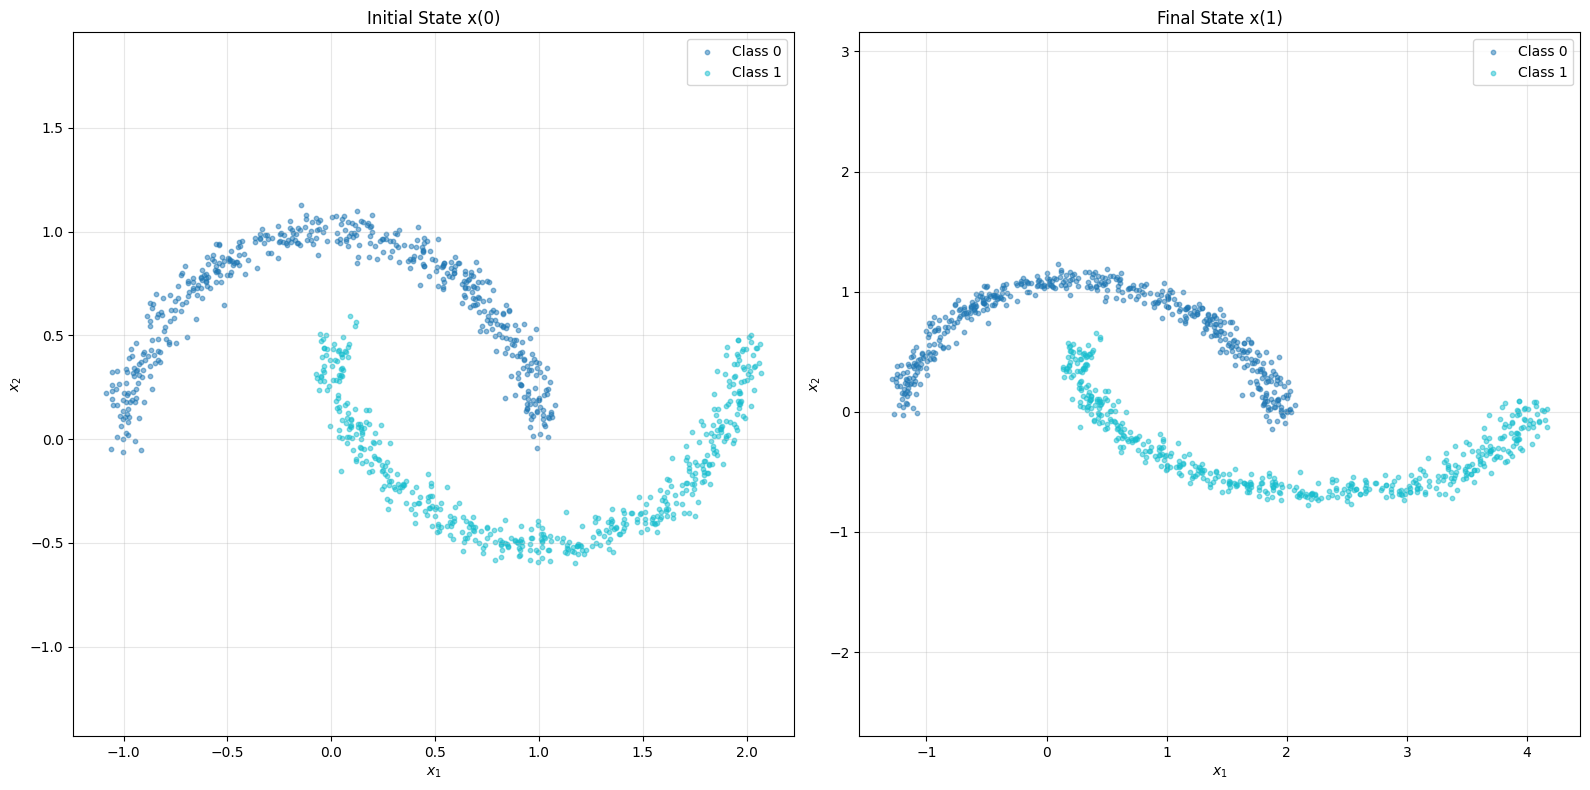

In [4]:
Synthetic2DViz.plot_trajectories(
    model,
    dataset,
    n_samples=1000,
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}_trajectories.png')
)
plt.tight_layout()
plt.show()


## 4. Visualizar Vector Field


Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png
Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png
Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png


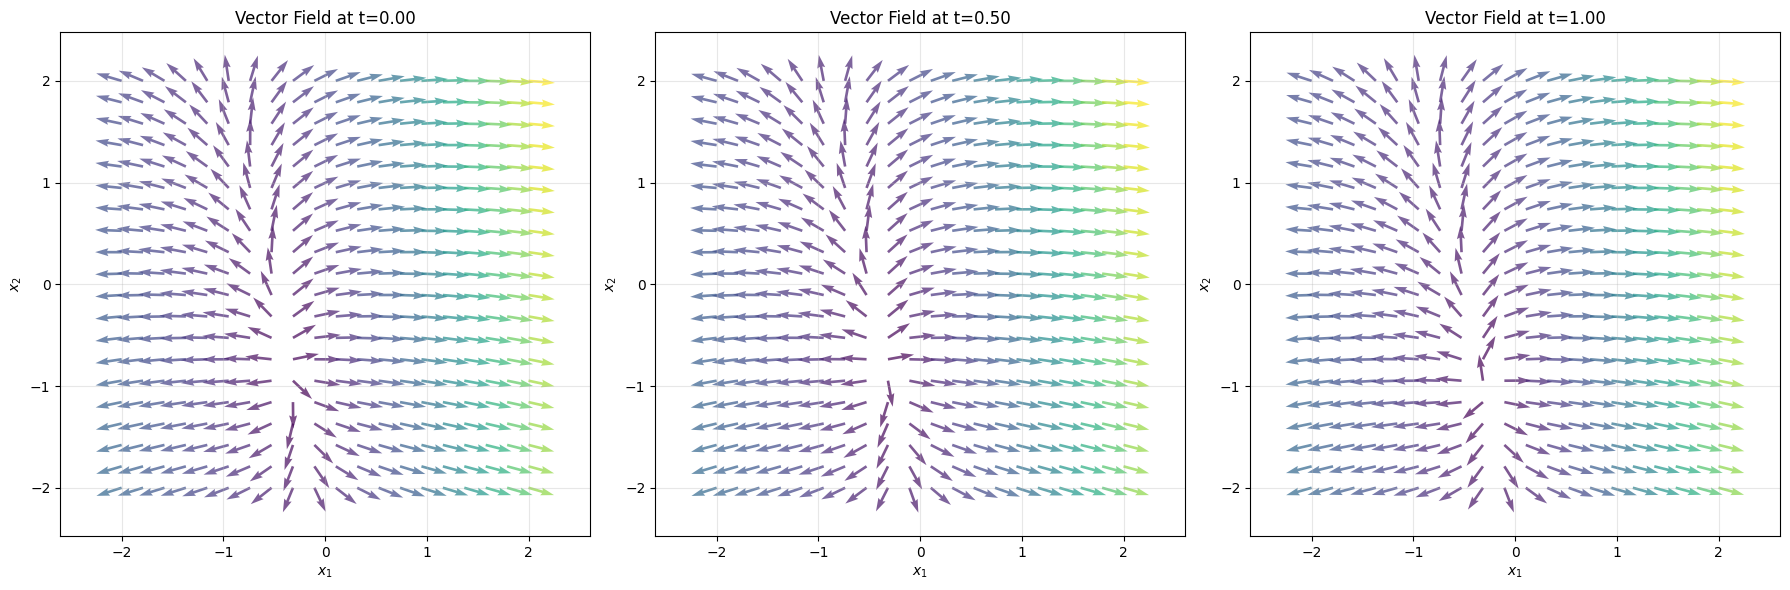

In [ ]:
# Plotar vector field em diferentes tempos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    Synthetic2DViz.plot_vector_field(
        model,
        xlim=(-2, 2),
        ylim=(-2, 2),
        n_grid=20,
        t=t,
        ax=axes[i],
        save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}_vector_fields.png')
    )
plt.tight_layout()
plt.show()


## 5. Visualizar Transformação


Figure saved to: ../results/figures/01_moons_neuralode_transformation.png


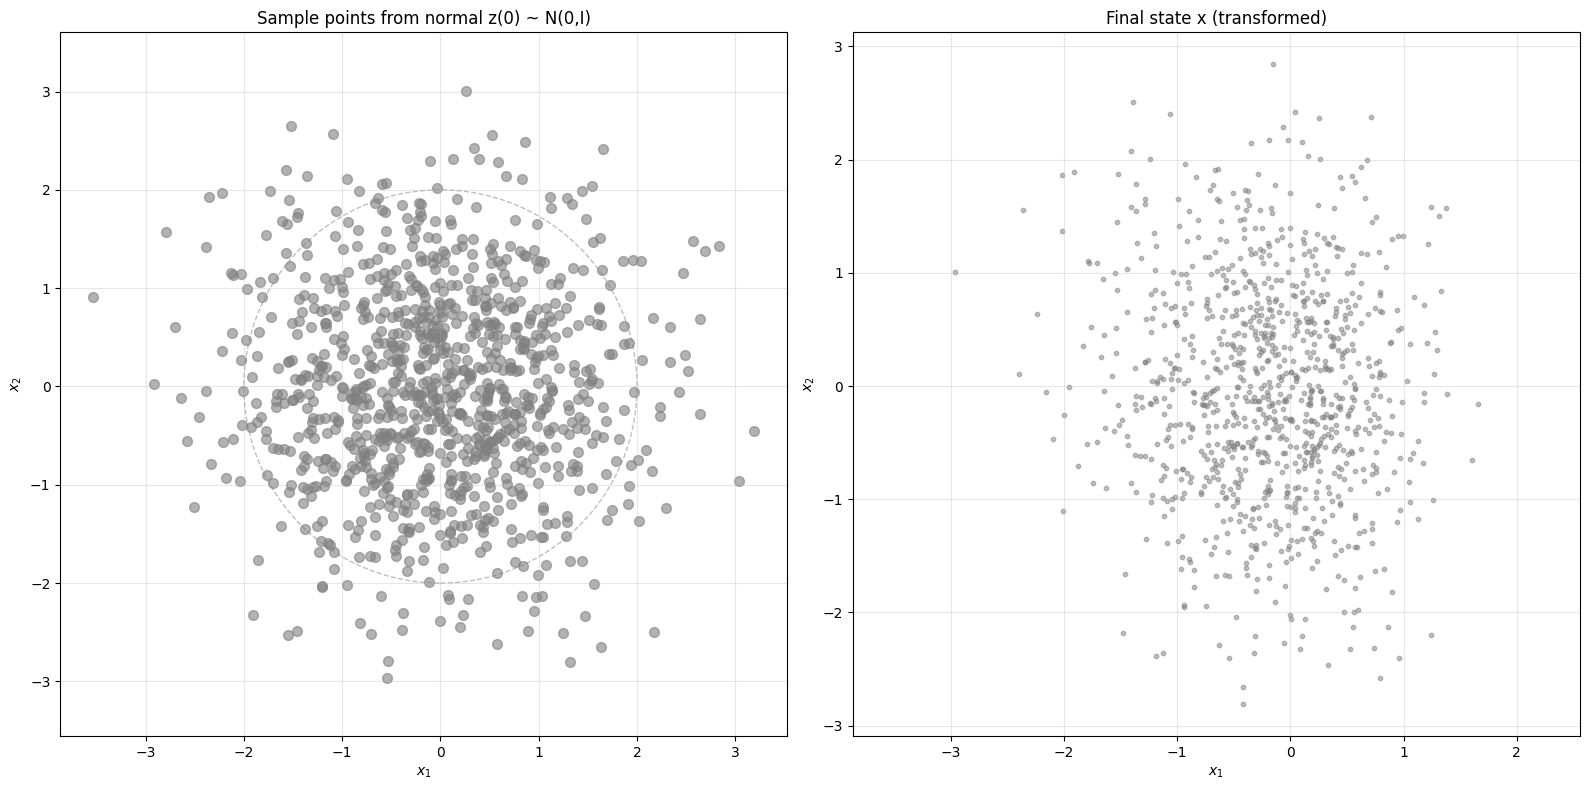

In [6]:
Synthetic2DViz.plot_transformation(
    model,
    n_samples=1000,
    n_points=100,
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}_transformation.png')
)
plt.tight_layout()
plt.show()


## 6. Analisar NFEs (Number of Function Evaluations)


In [ ]:
# Comparar diferentes solvers
solvers = ['euler', 'rk4', 'dopri5']
nfe_results = {}

# Usar amostras de N(0, I) para contagem de NFEs
sample_batch = torch.randn(10, 2).to(device)

print("=== Comparação de Solvers ===")
for solver in solvers:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver=solver,
        rtol=1e-3,
        atol=1e-4,
        num_classes=2
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    if model.classifier is not None:
        model_test.classifier.load_state_dict(model.classifier.state_dict())

    nfe = count_nfe(model_test, sample_batch)
    nfe_results[solver] = nfe
    print(f"{solver}: {nfe} NFEs")

# Comparar diferentes tolerâncias
tolerances = [(1e-2, 1e-3), (1e-3, 1e-4), (1e-4, 1e-5)]
nfe_tol_results = {}

print("\n=== Comparação de Tolerâncias (dopri5) ===")
for rtol, atol in tolerances:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver='dopri5',
        rtol=rtol,
        atol=atol,
        num_classes=2
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    if model.classifier is not None:
        model_test.classifier.load_state_dict(model.classifier.state_dict())

    nfe = count_nfe(model_test, sample_batch)
    nfe_tol_results[(rtol, atol)] = nfe
    print(f"rtol={rtol}, atol={atol}: {nfe} NFEs")
